# Basic Setup


### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import model_selection
from sklearn import ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

from sklearn.model_selection import cross_val_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModelForSeq2SeqLM
# likely will also require installation of the sentencepiece library

import stanza
# Will require downloading their English pre-trained models using the below command:
# stanza.download('en')

C:\Users\brhki\Anaconda3\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [1]:
import pytorch

ModuleNotFoundError: No module named 'pytorch'

### Check that GPU loaded correctly

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Begin creating NLP sentiment analysis pipeline

### Define various sentiment analysis models

In [4]:
# https://huggingface.co/gilf/english-yelp-sentiment
yelp_all = pipeline(task="sentiment-analysis", model = AutoModelForSequenceClassification.from_pretrained("gilf/english-yelp-sentiment"), tokenizer = AutoTokenizer.from_pretrained("gilf/english-yelp-sentiment"), device = 0, return_all_scores=True)

In [5]:
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
bert_all = pipeline(task="sentiment-analysis", model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment"), tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment"), device = 0, return_all_scores=True)

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [101]:
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
twit_all = pipeline(task="sentiment-analysis", model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment"), tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", model_max_length=500, truncation=True), device = 0, return_all_scores=True)

In [7]:
# https://huggingface.co/textattack/xlnet-large-cased-SST-2
xlnet_all = pipeline(task="sentiment-analysis", model = AutoModelForSequenceClassification.from_pretrained("textattack/xlnet-base-cased-SST-2"), tokenizer = AutoTokenizer.from_pretrained("textattack/xlnet-base-cased-SST-2"), device = 0, return_all_scores=True)

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [8]:
# https://huggingface.co/mrm8488/t5-base-finetuned-imdb-sentiment
imdb_all = pipeline(task="text2text-generation", model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment"), tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment"), device = 0)

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

In [9]:
# https://huggingface.co/textattack/albert-base-v2-SST-2
albert_all = pipeline(task="sentiment-analysis", model = AutoModelForSequenceClassification.from_pretrained("textattack/albert-base-v2-SST-2"), tokenizer = AutoTokenizer.from_pretrained("textattack/albert-base-v2-SST-2", use_fast=False), device = 0, return_all_scores=True)

Downloading:   0%|          | 0.00/732 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [10]:
stanza_top = stanza.Pipeline(lang='en', processors='tokenize,sentiment')

2021-07-17 11:48:47 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-07-17 11:48:47 INFO: Use device: gpu
2021-07-17 11:48:47 INFO: Loading: tokenize
2021-07-17 11:48:48 INFO: Loading: sentiment
2021-07-17 11:48:48 INFO: Done loading processors!


### Define pipeline for running sentiment analysis and charting output

In [11]:
# Function to run the sentiment analysis algorithm on a specific string of text
# and input the results into a tidy series
#
# ARGS:
# text - String of text to be analyzed
# model - one of "yelp", "bert", "twit", "xlnet", "albert", or "stanza"

def save_sentiment(text, model):
    # Run analyses and save results
    if model=="yelp":
        temp_all = yelp_all(text)

        # Output results into a dataframe
        d = pd.Series({'LABEL_0':temp_all[0][0]["score"], 'LABEL_1': temp_all[0][1]["score"], 'LABEL_2': temp_all[0][2]["score"], 'LABEL_3': temp_all[0][3]["score"], 'LABEL_4': temp_all[0][4]["score"]})
        d2 = pd.Series({'label_predict': d.idxmax(), 'label_prob': d.max()})
        d = d.append(d2)
    
    elif model=="bert":
        temp_all = bert_all(text)

        # Output results into a dataframe
        d = pd.Series({'LABEL_0':temp_all[0][0]["score"], 'LABEL_1': temp_all[0][1]["score"], 'LABEL_2': temp_all[0][2]["score"], 'LABEL_3': temp_all[0][3]["score"], 'LABEL_4': temp_all[0][4]["score"]})
        d2 = pd.Series({'label_predict': d.idxmax(), 'label_prob': d.max()})
        d = d.append(d2)

    elif model=="twit":
        temp_all = twit_all(text)

        # Output results into a dataframe
        d = pd.Series({'LABEL_0':temp_all[0][0]["score"], 'LABEL_2': temp_all[0][1]["score"], 'LABEL_4': temp_all[0][2]["score"]})
        d2 = pd.Series({'label_predict': d.idxmax(), 'label_prob': d.max()})
        d = d.append(d2)

    elif model=="xlnet":
        temp_all = xlnet_all(text)

        # Output results into a dataframe
        d = pd.Series({'LABEL_0':temp_all[0][0]["score"], 'LABEL_4': temp_all[0][1]["score"]})
        d2 = pd.Series({'label_predict': d.idxmax(), 'label_prob': d.max()})
        d = d.append(d2)

    elif model=="imdb":
        temp_all = imdb_all(text)

        # Output results into a dataframe
        if temp_all[0]["generated_text"]=="negative":
            d = pd.Series({'label_predict': "LABEL_0"})
        elif temp_all[0]["generated_text"]=="positive":
            d = pd.Series({'label_predict': "LABEL_4"})
        else:
            d = pd.Series({'label_predict': "LABEL_2"})

    elif model=="albert":
        temp_all = albert_all(text)

        # Output results into a dataframe
        d = pd.Series({'LABEL_0':temp_all[0][0]["score"], 'LABEL_4': temp_all[0][1]["score"]})
        d2 = pd.Series({'label_predict': d.idxmax(), 'label_prob': d.max()})
        d = d.append(d2)
    
    elif model=="stanza":
        temp = stanza_top(text)
        for i, sentence in enumerate(temp.sentences):
            if sentence.sentiment==0:
                d = pd.Series({'label_predict': "LABEL_0"})
            elif sentence.sentiment==1:
                d = pd.Series({'label_predict': "LABEL_2"})
            elif sentence.sentiment==2:
                d = pd.Series({'label_predict': "LABEL_4"})

    # Print it
    return d
  

In [12]:
def get_sentiment(dataset, text_column, model):
    start_time = time.time()

    temp = dataset[text_column].apply(save_sentiment, model=model)
    print("--- %s seconds ---" % (time.time() - start_time))
    temp = pd.concat([dataset, temp], axis=1)
    return temp

In [13]:
# Function to quickly and visually display the accuracy metrics of the sentiment
# analysis algorithm in a confusion matrix and standard measures
#
# ARGS:
# truevals - Dataframe column of true values
# predictvals - Dataframe column of predicted values

def prediction_test(truevals, predictvals):
    sns.set(font_scale=1.2, rc={'figure.figsize':(11.7,8.27)})
    cm = confusion_matrix(truevals, predictvals)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Greens', fmt='g')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    print(classification_report(truevals, predictvals))

# Apply to Stanford Sentiment Treebank and Benchmark

### Load in Stanford Sentiment Treebank to benchmark performance

In [18]:
sst5_train = pd.read_csv("../../N2FL NLP/data/train.tsv", sep="\t", encoding='utf-8')
# source: https://raw.githubusercontent.com/brhkim/Albert-Sentiment-Analysis/master/data/train.tsv
sst5_test = pd.read_csv("../../N2FL NLP/data/test.tsv", sep="\t", encoding='utf-8')
# source: https://raw.githubusercontent.com/brhkim/Albert-Sentiment-Analysis/master/data/test.tsv

In [19]:
# Basic relabeling to mesh with algorithm output
sst5_train.loc[sst5_train.label == "very neg", "label"] = "LABEL_0"
sst5_train.loc[sst5_train.label == "neg", "label"] = "LABEL_1"
sst5_train.loc[sst5_train.label == "neu", "label"] = "LABEL_2"
sst5_train.loc[sst5_train.label == "pos", "label"] = "LABEL_3"
sst5_train.loc[sst5_train.label == "very pos", "label"] = "LABEL_4"

In [20]:
sst5_test.loc[sst5_test.label == "very neg", "label"] = "LABEL_0"
sst5_test.loc[sst5_test.label == "neg", "label"] = "LABEL_1"
sst5_test.loc[sst5_test.label == "neu", "label"] = "LABEL_2"
sst5_test.loc[sst5_test.label == "pos", "label"] = "LABEL_3"
sst5_test.loc[sst5_test.label == "very pos", "label"] = "LABEL_4"

In [21]:
# Preview test dataset
sst5_test.sample(5, random_state=1234)

,text,label
1417,I loved looking at this movie .,LABEL_3
797,"Just like the deli sandwich : lots of ham , lo...",LABEL_2
908,The saturation bombing of Reggio 's images and...,LABEL_1
815,"If this movie were a book , it would be a page...",LABEL_4
1443,"If you liked the 1982 film then , you 'll stil...",LABEL_4


In [22]:
# Make a 3-class SST dataset
sst3_train = sst5_train.copy()
sst3_train.loc[sst3_train.label == "LABEL_1", "label"] = "LABEL_0"
sst3_train.loc[sst3_train.label == "LABEL_3", "label"] = "LABEL_4"

sst3_test = sst5_test.copy()
sst3_test.loc[sst3_test.label == "LABEL_1", "label"] = "LABEL_0"
sst3_test.loc[sst3_test.label == "LABEL_3", "label"] = "LABEL_4"

In [23]:
sst3_test.sample(5, random_state=1234)

,text,label
1417,I loved looking at this movie .,LABEL_4
797,"Just like the deli sandwich : lots of ham , lo...",LABEL_2
908,The saturation bombing of Reggio 's images and...,LABEL_0
815,"If this movie were a book , it would be a page...",LABEL_4
1443,"If you liked the 1982 film then , you 'll stil...",LABEL_4


In [24]:
# Make a 2-class SST dataset
sst2_train = sst3_train[sst3_train['label']!="LABEL_2"].copy()
sst2_test = sst3_test[sst3_test['label']!="LABEL_2"].copy()

# Run and evaluate various sentiment analysis pipelines on SST data

### Yelp BERT model

In [25]:
yelp_test = get_sentiment(sst5_test, "text", "yelp")

--- 18.70186495780945 seconds ---


In [26]:
yelp_test.sample(5, random_state=1236)

,text,label,LABEL_0,LABEL_1,LABEL_2,LABEL_3,LABEL_4,label_predict,label_prob
2094,Much-anticipated and ultimately lackluster mov...,LABEL_1,0.044354,0.530681,0.414884,0.009627,0.000453,LABEL_1,0.530681
1835,A model of what films like this should be like .,LABEL_4,0.343731,0.341812,0.165734,0.068656,0.080068,LABEL_0,0.343731
613,This cuddly sequel to the 1999 hit is a little...,LABEL_3,0.001998,0.057504,0.665670,0.260657,0.014172,LABEL_2,0.665670
708,Not even the Hanson Brothers can save it,LABEL_0,0.674523,0.220520,0.058653,0.018783,0.027522,LABEL_0,0.674523
113,Going to the website may be just as fun ( and ...,LABEL_1,0.297956,0.290639,0.248756,0.094182,0.068468,LABEL_0,0.297956


              precision    recall  f1-score   support

     LABEL_0       0.30      0.56      0.39       279
     LABEL_1       0.51      0.40      0.45       633
     LABEL_2       0.27      0.32      0.29       389
     LABEL_3       0.44      0.25      0.32       510
     LABEL_4       0.50      0.56      0.53       399

    accuracy                           0.40      2210
   macro avg       0.40      0.42      0.40      2210
weighted avg       0.42      0.40      0.40      2210



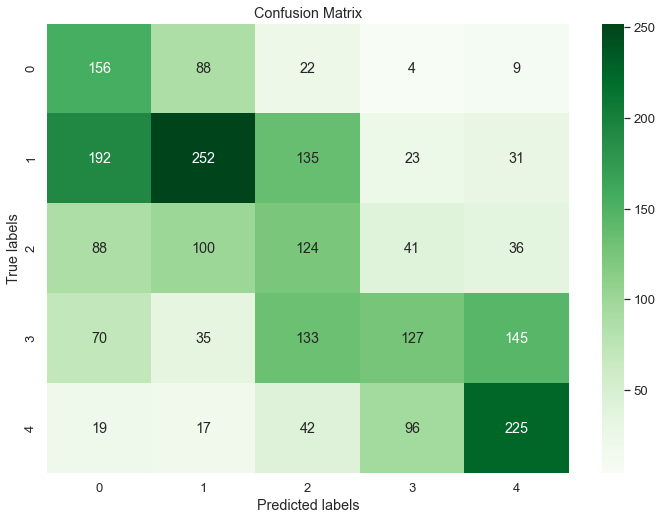

In [27]:
prediction_test(yelp_test["label"], yelp_test["label_predict"])
plt.savefig('../../N2FL NLP/output/03a_yelp_test.png')

### Stanza Sentiment Analysis CNN

In [28]:
stanza_test = get_sentiment(sst3_test, "text", "stanza")

C:\Users\brhki\Anaconda3\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


--- 12.124010562896729 seconds ---


In [29]:
stanza_test.sample(5, random_state=1237)

,text,label,label_predict
2026,An impressive debut for first-time writer-dire...,LABEL_4,LABEL_4
277,Herzog is obviously looking for a moral to his...,LABEL_0,LABEL_0
307,Looks like a high school film project complete...,LABEL_0,LABEL_0
1423,A pleasant romantic comedy .,LABEL_4,LABEL_4
116,It 's both a necessary political work and a fa...,LABEL_4,LABEL_4


              precision    recall  f1-score   support

     LABEL_0       0.71      0.79      0.75       912
     LABEL_2       0.36      0.27      0.31       389
     LABEL_4       0.78      0.79      0.79       909

    accuracy                           0.70      2210
   macro avg       0.62      0.62      0.61      2210
weighted avg       0.68      0.70      0.69      2210



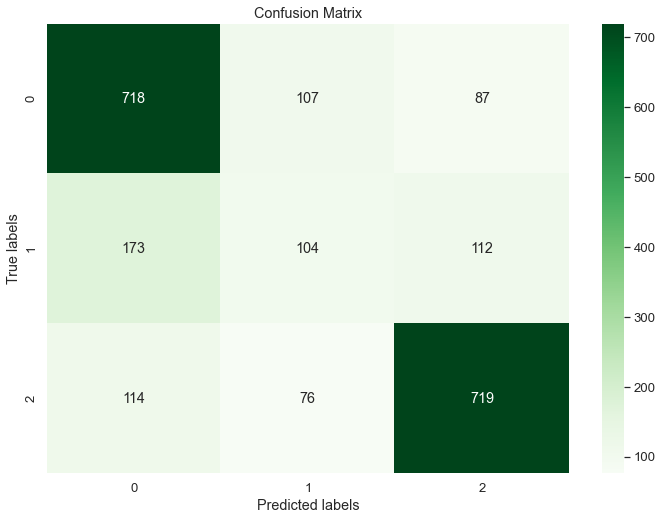

In [30]:
prediction_test(stanza_test["label"], stanza_test["label_predict"])
plt.savefig('../../N2FL NLP/output/03a_stanza_test.png')

### TextAttack Albert Model

In [31]:
albert_test = get_sentiment(sst2_test, "text", "albert")

--- 17.370097160339355 seconds ---


In [32]:
albert_test.head()

,text,label,LABEL_0,LABEL_4,label_predict,label_prob
0,Maybe I found the proceedings a little bit too...,LABEL_0,0.994027,0.005973,LABEL_0,0.994027
1,"As with too many studio pics , plot mechanics ...",LABEL_0,0.982890,0.017110,LABEL_0,0.982890
3,"Cute , funny , heartwarming digitally animated...",LABEL_4,0.000394,0.999606,LABEL_4,0.999606
4,So what is the point ?,LABEL_0,0.908975,0.091025,LABEL_0,0.908975
5,While this film is not in the least surprising...,LABEL_4,0.004962,0.995039,LABEL_4,0.995039


              precision    recall  f1-score   support

     LABEL_0       0.91      0.93      0.92       912
     LABEL_4       0.93      0.90      0.92       909

    accuracy                           0.92      1821
   macro avg       0.92      0.92      0.92      1821
weighted avg       0.92      0.92      0.92      1821



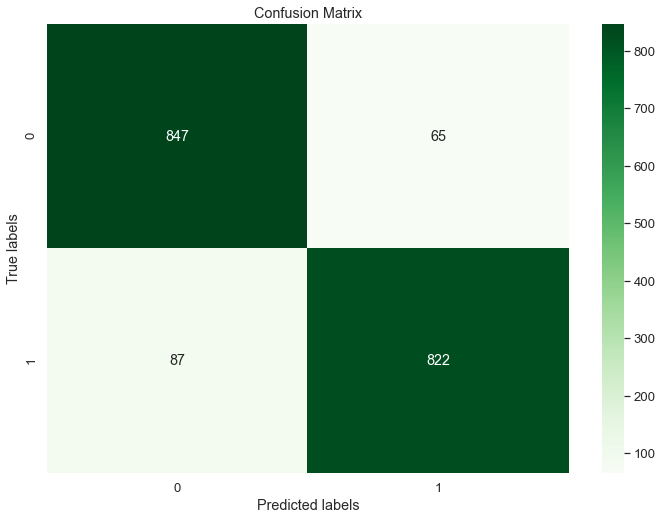

In [33]:
prediction_test(albert_test["label"], albert_test["label_predict"])
plt.savefig('../../N2FL NLP/output/03a_albert_test.png')

### TextAttack XLNet Model

In [34]:
xlnet_test = get_sentiment(sst2_test, "text", "xlnet")

--- 26.991369009017944 seconds ---


In [35]:
xlnet_test.head()

,text,label,LABEL_0,LABEL_4,label_predict,label_prob
0,Maybe I found the proceedings a little bit too...,LABEL_0,0.999385,0.000615,LABEL_0,0.999385
1,"As with too many studio pics , plot mechanics ...",LABEL_0,0.995378,0.004622,LABEL_0,0.995378
3,"Cute , funny , heartwarming digitally animated...",LABEL_4,0.000146,0.999854,LABEL_4,0.999854
4,So what is the point ?,LABEL_0,0.998688,0.001312,LABEL_0,0.998688
5,While this film is not in the least surprising...,LABEL_4,0.000351,0.999649,LABEL_4,0.999649


              precision    recall  f1-score   support

     LABEL_0       0.96      0.92      0.94       912
     LABEL_4       0.92      0.96      0.94       909

    accuracy                           0.94      1821
   macro avg       0.94      0.94      0.94      1821
weighted avg       0.94      0.94      0.94      1821



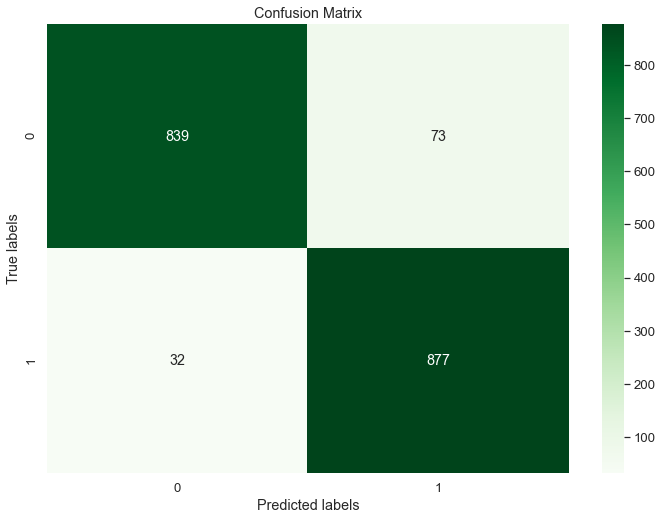

In [36]:
prediction_test(xlnet_test["label"], xlnet_test["label_predict"])
plt.savefig('../../N2FL NLP/output/03a_xlnet_test.png')

### Multilingual Bert

In [37]:
bert_test = get_sentiment(sst5_test, "text", "bert")

--- 18.359389305114746 seconds ---


In [38]:
bert_test.head()

,text,label,LABEL_0,LABEL_1,LABEL_2,LABEL_3,LABEL_4,label_predict,label_prob
0,Maybe I found the proceedings a little bit too...,LABEL_1,0.018266,0.199258,0.692711,0.084829,0.004935,LABEL_2,0.692711
1,"As with too many studio pics , plot mechanics ...",LABEL_0,0.019846,0.148343,0.468962,0.290217,0.072632,LABEL_2,0.468962
2,"Beers , who , when she 's given the right line...",LABEL_2,0.089036,0.364925,0.450885,0.087195,0.007959,LABEL_2,0.450885
3,"Cute , funny , heartwarming digitally animated...",LABEL_4,0.002127,0.005679,0.078588,0.591100,0.322506,LABEL_3,0.591100
4,So what is the point ?,LABEL_0,0.187678,0.259849,0.380600,0.120298,0.051575,LABEL_2,0.380600


              precision    recall  f1-score   support

     LABEL_0       0.39      0.40      0.39       279
     LABEL_1       0.57      0.38      0.45       633
     LABEL_2       0.28      0.37      0.32       389
     LABEL_3       0.44      0.45      0.44       510
     LABEL_4       0.45      0.54      0.49       399

    accuracy                           0.42      2210
   macro avg       0.43      0.43      0.42      2210
weighted avg       0.45      0.42      0.43      2210



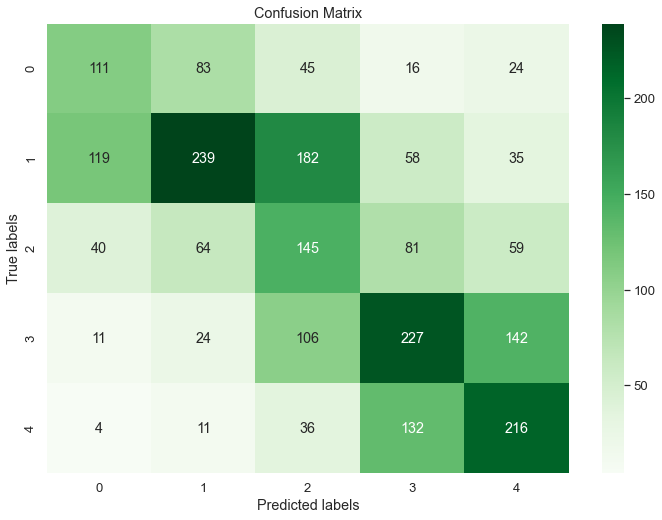

In [39]:
prediction_test(bert_test["label"], bert_test["label_predict"])
plt.savefig('../../N2FL NLP/output/03a_bert_test.png')

### Twitter Roberta

In [40]:
twit_test = get_sentiment(sst3_test, "text", "twit")

--- 18.674803018569946 seconds ---


In [41]:
twit_test.head()

,text,label,LABEL_0,LABEL_2,LABEL_4,label_predict,label_prob
0,Maybe I found the proceedings a little bit too...,LABEL_0,0.616782,0.363378,0.019840,LABEL_0,0.616782
1,"As with too many studio pics , plot mechanics ...",LABEL_0,0.615623,0.349694,0.034683,LABEL_0,0.615623
2,"Beers , who , when she 's given the right line...",LABEL_2,0.588146,0.376454,0.035400,LABEL_0,0.588146
3,"Cute , funny , heartwarming digitally animated...",LABEL_4,0.001602,0.024440,0.973958,LABEL_4,0.973958
4,So what is the point ?,LABEL_0,0.222961,0.730845,0.046194,LABEL_2,0.730845


              precision    recall  f1-score   support

     LABEL_0       0.80      0.66      0.72       912
     LABEL_2       0.29      0.55      0.38       389
     LABEL_4       0.85      0.67      0.75       909

    accuracy                           0.65      2210
   macro avg       0.65      0.63      0.62      2210
weighted avg       0.73      0.65      0.67      2210



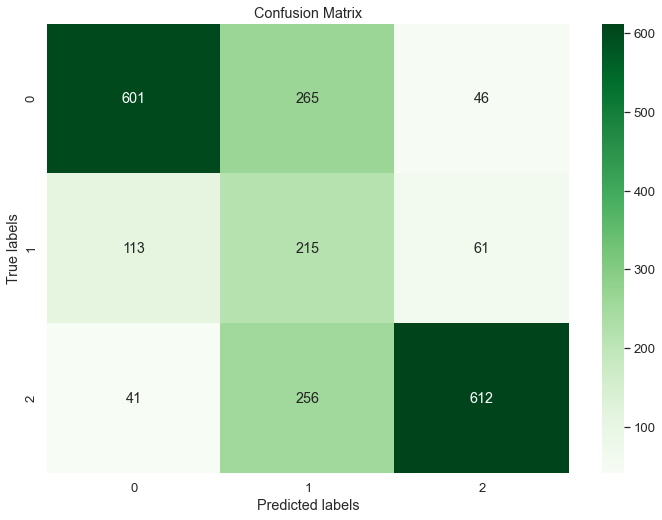

In [42]:
prediction_test(twit_test["label"], twit_test["label_predict"])
plt.savefig('../../N2FL NLP/output/03a_twit_test.png')

### T5 IMDB

In [43]:
imdb_test = get_sentiment(sst2_test, "text", "imdb")

--- 54.483091831207275 seconds ---


In [44]:
imdb_test.head()

,text,label,label_predict
0,Maybe I found the proceedings a little bit too...,LABEL_0,LABEL_0
1,"As with too many studio pics , plot mechanics ...",LABEL_0,LABEL_0
3,"Cute , funny , heartwarming digitally animated...",LABEL_4,LABEL_4
4,So what is the point ?,LABEL_0,LABEL_0
5,While this film is not in the least surprising...,LABEL_4,LABEL_4


In [45]:
imdb_test[imdb_test["label_predict"]=="LABEL_2"]

,text,label,label_predict
43,No. .,LABEL_0,LABEL_2


              precision    recall  f1-score   support

     LABEL_0       0.96      0.85      0.90       912
     LABEL_2       0.00      0.00      0.00         0
     LABEL_4       0.86      0.96      0.91       909

    accuracy                           0.90      1821
   macro avg       0.61      0.60      0.60      1821
weighted avg       0.91      0.90      0.90      1821



C:\Users\brhki\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brhki\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brhki\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


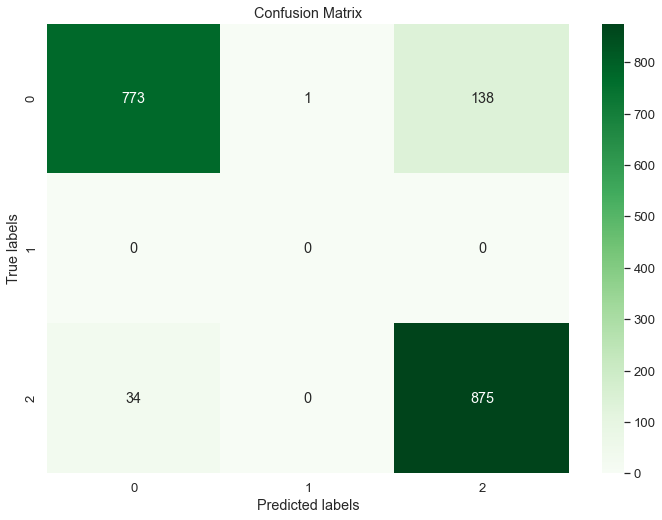

In [46]:
prediction_test(imdb_test["label"], imdb_test["label_predict"])
plt.savefig('../../N2FL NLP/output/03a_imdb_test.png')

# Create datasets for training the ensemble classifier

### Create training data

In [47]:
yelp_train = get_sentiment(sst5_train, "text", "yelp").drop(columns=["text", "label"]).add_suffix("_yelp")

--- 72.19711542129517 seconds ---


In [49]:
xlnet_train = get_sentiment(sst5_train, "text", "xlnet").drop(columns=["text", "label"]).add_suffix("_xlnet")

--- 126.10802626609802 seconds ---


In [48]:
albert_train = get_sentiment(sst5_train, "text", "albert").drop(columns=["text", "label"]).add_suffix("_albert")

--- 81.2988178730011 seconds ---


In [50]:
stanza_train = get_sentiment(sst5_train, "text", "stanza").drop(columns=["text", "label"]).add_suffix("_stanza")

--- 45.74189591407776 seconds ---


In [51]:
bert_train = get_sentiment(sst5_train, "text", "bert").drop(columns=["text", "label"]).add_suffix("_bert")

--- 74.56437921524048 seconds ---


In [52]:
twit_train = get_sentiment(sst5_train, "text", "twit").drop(columns=["text", "label"]).add_suffix("_twit")

--- 72.83663725852966 seconds ---


In [53]:
imdb_train = get_sentiment(sst5_train, "text", "imdb").drop(columns=["text", "label"]).add_suffix("_imdb")

--- 258.688707113266 seconds ---


#### Merge datasets together

In [54]:
forest_train = pd.merge(sst5_train, yelp_train, how="inner", left_index=True, right_index=True, validate="1:1")

In [56]:
forest_train = pd.merge(forest_train, xlnet_train, how="inner", left_index=True, right_index=True, validate="1:1")

In [55]:
forest_train = pd.merge(forest_train, albert_train, how="inner", left_index=True, right_index=True, validate="1:1")

In [57]:
forest_train = pd.merge(forest_train, stanza_train, how="inner", left_index=True, right_index=True, validate="1:1")

In [58]:
forest_train = pd.merge(forest_train, bert_train, how="inner", left_index=True, right_index=True, validate="1:1")

In [59]:
forest_train = pd.merge(forest_train, twit_train, how="inner", left_index=True, right_index=True, validate="1:1")

In [60]:
forest_train = pd.merge(forest_train, imdb_train, how="inner", left_index=True, right_index=True, validate="1:1")

In [61]:
forest_train.to_csv('../../N2FL NLP/data/03a_sst5_train.csv')

### Create testing data

In [62]:
yelp_test = get_sentiment(sst5_test, "text", "yelp").drop(columns=["text", "label"]).add_suffix("_yelp")

--- 18.914270639419556 seconds ---


In [64]:
xlnet_test = get_sentiment(sst5_test, "text", "xlnet").drop(columns=["text", "label"]).add_suffix("_xlnet")

--- 31.96621823310852 seconds ---


In [63]:
albert_test = get_sentiment(sst5_test, "text", "albert").drop(columns=["text", "label"]).add_suffix("_albert")

--- 20.813700199127197 seconds ---


In [65]:
stanza_test = get_sentiment(sst5_test, "text", "stanza").drop(columns=["text", "label"]).add_suffix("_stanza")

--- 11.963701486587524 seconds ---


In [66]:
bert_test = get_sentiment(sst5_test, "text", "bert").drop(columns=["text", "label"]).add_suffix("_bert")

--- 18.614203691482544 seconds ---


In [67]:
twit_test = get_sentiment(sst5_test, "text", "twit").drop(columns=["text", "label"]).add_suffix("_twit")

--- 18.673217058181763 seconds ---


In [68]:
imdb_test = get_sentiment(sst5_test, "text", "imdb").drop(columns=["text", "label"]).add_suffix("_imdb")

--- 65.56285190582275 seconds ---


#### Merge datasets together

In [69]:
forest_test = pd.merge(sst5_test, yelp_test, how="inner", left_index=True, right_index=True, validate="1:1")

In [71]:
forest_test = pd.merge(forest_test, xlnet_test, how="inner", left_index=True, right_index=True, validate="1:1")

In [70]:
forest_test = pd.merge(forest_test, albert_test, how="inner", left_index=True, right_index=True, validate="1:1")

In [72]:
forest_test = pd.merge(forest_test, stanza_test, how="inner", left_index=True, right_index=True, validate="1:1")

In [73]:
forest_test = pd.merge(forest_test, bert_test, how="inner", left_index=True, right_index=True, validate="1:1")

In [74]:
forest_test = pd.merge(forest_test, twit_test, how="inner", left_index=True, right_index=True, validate="1:1")

In [75]:
forest_test = pd.merge(forest_test, imdb_test, how="inner", left_index=True, right_index=True, validate="1:1")

In [76]:
forest_test.to_csv('../../N2FL NLP/data/03a_sst5_test.csv')

# Apply to the analytic dataset

### Load in and organize the analytic data

In [77]:
data = pd.read_stata('../../N2FL NLP/data/02_advisornames_cleaned_unique.dta')
data["index"]=data.index
data.shape

(52458, 2)

In [78]:
data.head()

,text,index
0,"Hi, I'm a KCC advisor, & I'm here to support y...",0
1,Hi. Fafsa.gov is open for the 2018-2019 school...,1
2,Hi. I'm at Austin Community College & I'm here...,2
3,Hi. Spring 2019 registration is open. Can I he...,3
4,"Hi. Some students face financial hardships, in...",4


### Apply the Sentiment Analysis algorithms to the analytic data

In [79]:
data_yelp = get_sentiment(data, "text", "yelp").add_suffix("_yelp")

--- 437.67514634132385 seconds ---


In [81]:
data_xlnet = get_sentiment(data, "text", "xlnet").add_suffix("_xlnet")

--- 747.4564311504364 seconds ---


In [80]:
data_albert = get_sentiment(data, "text", "albert").add_suffix("_albert")

--- 496.4290454387665 seconds ---


In [86]:
# Minor cleaning steps because Stanza can't take empty rows
stanza_prep = data.copy()
stanza_prep["str_len"] = stanza_prep["text"].str.len()
stanza_prep = stanza_prep[stanza_prep['str_len'] >= 2].drop(columns=["str_len"])

In [88]:
data_stanza = get_sentiment(stanza_prep, "text", "stanza").add_suffix("_stanza")

--- 261.8666989803314 seconds ---


In [89]:
data_bert = get_sentiment(data, "text", "bert").add_suffix("_bert")

--- 436.46775245666504 seconds ---


In [95]:
# Minor cleaning steps because there's a max string length
twit_prep = data.copy()
twit_prep["str_len"] = twit_prep["text"].str.len()
twit_prep = twit_prep[twit_prep['str_len'] <= 400].drop(columns=["str_len"])

In [102]:
data_twit = get_sentiment(twit_prep, "text", "twit").add_suffix("_twit")

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 500). Running this sequence through the model will result in indexing errors


RuntimeError: The expanded size of the tensor (668) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 668].  Tensor sizes: [1, 514]

In [106]:
# Minor cleaning steps because imdb can't take non-ascii characters apparently
imdb_prep = data.copy()
imdb_prep["text"] = imdb_prep["text"].str.encode("ascii", "ignore").str.decode("ascii")

In [107]:
data_imdb = get_sentiment(imdb_prep, "text", "imdb").add_suffix("_imdb")

--- 1638.4484975337982 seconds ---


### Join sentiment scores back into the main dataset

In [112]:
data_analyze = pd.merge(data, data_yelp, how="inner", left_on="index", right_on="index_yelp", validate="1:1").drop(columns=["text_yelp", "index_yelp"])

In [113]:
data_analyze = pd.merge(data_analyze, data_xlnet, how="inner", left_on="index", right_on="index_xlnet", validate="1:1").drop(columns=["text_xlnet", "index_xlnet"])

In [114]:
data_analyze = pd.merge(data_analyze, data_albert, how="inner", left_on="index", right_on="index_albert", validate="1:1").drop(columns=["text_albert", "index_albert"])

In [115]:
data_analyze = pd.merge(data_analyze, data_stanza, how="inner", left_on="index", right_on="index_stanza", validate="1:1").drop(columns=["text_stanza", "index_stanza"])

In [116]:
data_analyze = pd.merge(data_analyze, data_bert, how="inner", left_on="index", right_on="index_bert", validate="1:1").drop(columns=["text_bert", "index_bert"])

In [117]:
data_analyze = pd.merge(data_analyze, data_twit, how="inner", left_on="index", right_on="index_twit", validate="1:1").drop(columns=["text_twit", "index_twit"])

In [118]:
data_analyze = pd.merge(data_analyze, data_imdb, how="inner", left_on="index", right_on="index_imdb", validate="1:1").drop(columns=["text_imdb", "index_imdb"])

In [119]:
data_analyze.shape

(52164, 31)

In [120]:
data_analyze.sample(10, random_state=1234)

,text,index,LABEL_0_yelp,LABEL_1_yelp,LABEL_2_yelp,LABEL_3_yelp,LABEL_4_yelp,label_predict_yelp,label_prob_yelp,LABEL_0_xlnet,...,LABEL_3_bert,LABEL_4_bert,label_predict_bert,label_prob_bert,LABEL_0_twit,LABEL_2_twit,LABEL_4_twit,label_predict_twit,label_prob_twit,label_predict_imdb
15726,Really all great options! GMU has a Transfer S...,15793,0.002457,0.004904,0.080207,0.546224,0.366208,LABEL_3,0.546224,0.003157,...,0.231343,0.726762,LABEL_4,0.726762,0.001751,0.042814,0.955435,LABEL_4,0.955435,LABEL_4
28908,Yes. you will complete EMT AAS program in Fall...,29036,0.022288,0.019506,0.073199,0.248149,0.636857,LABEL_4,0.636857,0.017205,...,0.293369,0.355197,LABEL_4,0.355197,0.005365,0.551490,0.443145,LABEL_2,0.551490,LABEL_4
5648,Yes u can,5692,0.056423,0.058126,0.221824,0.346719,0.316909,LABEL_3,0.346719,0.004031,...,0.239441,0.510596,LABEL_4,0.510596,0.009988,0.218118,0.771895,LABEL_4,0.771895,LABEL_4
13421,How about next Tuesday (2/13) at 2:00?,13480,0.197279,0.192458,0.353186,0.174817,0.082260,LABEL_2,0.353186,0.700990,...,0.054731,0.039769,LABEL_0,0.485427,0.021914,0.931711,0.046375,LABEL_2,0.931711,LABEL_4
12395,My name is - I am a Mobile Academic Advisor fo...,12454,0.193696,0.087219,0.173809,0.228734,0.316542,LABEL_4,0.316542,0.030049,...,0.280935,0.472071,LABEL_4,0.472071,0.011784,0.898503,0.089713,LABEL_2,0.898503,LABEL_4
22398,appointment with any of the advisors available...,22497,0.012195,0.010705,0.047738,0.219233,0.710129,LABEL_4,0.710129,0.001060,...,0.396337,0.480860,LABEL_4,0.480860,0.001491,0.082956,0.915553,LABEL_4,0.915553,LABEL_4
31964,Oh wow thanks!,32103,0.028997,0.014281,0.033663,0.163731,0.759328,LABEL_4,0.759328,0.000389,...,0.167038,0.755589,LABEL_4,0.755589,0.002601,0.033757,0.963642,LABEL_4,0.963642,LABEL_4
5860,"Ok. That's a lot. How can I get scholarships, ...",5905,0.509104,0.344188,0.123805,0.014865,0.008037,LABEL_0,0.509104,0.997489,...,0.065714,0.005415,LABEL_2,0.775118,0.442557,0.507168,0.050275,LABEL_2,0.507168,LABEL_0
20562,Let me go talk to Financial Aid and see what t...,20650,0.794355,0.130790,0.060889,0.009323,0.004642,LABEL_0,0.794355,0.034700,...,0.146523,0.335772,LABEL_4,0.335772,0.032476,0.895701,0.071823,LABEL_2,0.895701,LABEL_4
40024,Thank you I would highly appreciate it because...,40208,0.149719,0.122106,0.167176,0.191398,0.369601,LABEL_4,0.369601,0.004801,...,0.287317,0.280695,LABEL_3,0.287317,0.001174,0.017342,0.981484,LABEL_4,0.981484,LABEL_4


### Output the dataset

In [121]:
filepath = '../../N2FL NLP/data/03a_sentiment_prep_masked.csv'

In [122]:
data_analyze.to_csv(filepath)